<a href="https://colab.research.google.com/github/RomainHerault/PRD/blob/master/Version_refactoris%C3%A9e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%flake8_off

In [0]:
#Variables globales
segment_installed = False
lime_installed = False


#Preprocessing

In [0]:
import torch
import numpy as np
import copy
import os
import shutil
import cv2
import re
import torch.nn.functional as F
from google.colab.patches import cv2_imshow
from skimage.color import gray2rgb, rgb2gray

class Classifier:
    """
    This class contains the elements refering to the classifier used
    Here, it's a R2Plus1D to work with videos
    """
    def __init__(self, model, conversion_input_function):
        """
        Initialisation, we define the kind of model we want to use
        """
        self.model = model.cuda()
        self.conversion_input_function = conversion_input_function

    def load_model(self, path_model=None):
        """Load the trained model
        Args :
            path_model : the path of the model file
        """
        if path_model is not None and os.path.exists(path_model):
            print('Pretrained Model existed')
            bestModelWts = torch.load(path_model)
            if type(bestModelWts) is dict:
                self.model.load_state_dict(bestModelWts['bestModelWts'])
            else:
                self.model.load_state_dict(bestModelWts)
        else:
            print("Le modèle n'est pas entraîné")
            bestModelWts = copy.deepcopy(
                self.model.state_dict())  # Copier les paramètres initiaux du modèle

    def batch_predict(self, images_list):
        """Evaluation method, it must take in input the
        model input (a list of images) and return the probabilities of each class
        predicted by the black box
        """
        model_input = self.conversion_input_function(images_list)
        outputs = self.model(model_input.cuda().float())
        probs = F.softmax(outputs, dim=1)
        return probs.detach().cpu().numpy()


class Input_processing:
    """This class contains methos to process the data we want to pass in input
    """
    def __init__(self, video_path):
        """Initialization functions
        Args:
            video_path : the path of the folder that contains the images
            corresponding to the video
        """
        self.video_path = video_path

    def store_video_in_one_folder(self, number_images):
        """This method takes the firsts images of the video folder, copies them
        into a new folder and renames them.
        Its usefull for the segmentation.
        Args :
            number_images : the number of images you want to keep in the final
            video
        """
        num_images = 0
        path = self.video_path
        self.temp_video_folder = os.path.basename(path) + "_video"
        if os.path.isdir(self.temp_video_folder):
            if len(os.listdir(
                    self.temp_video_folder)) == number_images:  # TODO Check if -1 or not
                # Directory already exists and contains the correct number of files
                return self.temp_video_folder
        else:
            os.mkdir(self.temp_video_folder)
        sub_folders = [f.path for f in os.scandir(path) if f.is_dir()]
        sub_folders.sort(key=lambda f: int(re.sub('\D', '', f)))
        for filepath in (sub_folders):
            numFolder = int(os.path.basename(filepath))
            files = os.listdir(filepath)
            files.sort(key=lambda f: int(re.sub('\D', '', f)))
            for filename in files:
                base, extension = os.path.splitext(filename)
                num_file = numFolder * 30 + int(base)
                if (num_images < num_file):
                    num_images = num_file
                new_name = os.path.join(self.temp_video_folder,
                                        format(num_file, '05d') + extension)
                shutil.copy(os.path.join(filepath, filename), new_name)
                if num_file + 1 >= number_images:
                    return self.temp_video_folder
        return self.temp_video_folder

    def split_video_in_images(self, sequence_length = 25):
        cap = cv2.VideoCapture(self.video_path)
        fn_fps = int(cap.get(cv2.CAP_PROP_FPS))
        if fn_fps > 30:
            downsample_rate = int(fn_fps / 25)
        else: 
            downsample_rate = 1
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        hw_ratio = frame_height/frame_width
        wh_ratio = frame_width/frame_height
        if frame_width > 256:
            frame_width = 256
            frame_height = int(hw_ratio * frame_width)
        
        if frame_height > 256:
            frame_height = 256
            frame_width = int(wh_ratio * frame_height)       

        #frame_block = np.empty((0,frame_height,frame_width,3))

        print(fn_fps)
        print(frame_count)
        print(frame_height)
        print(frame_width)
        path = self.video_path
        self.temp_video_folder = os.path.basename(path) + "_video"

        if not os.path.isdir(self.temp_video_folder):
            os.mkdir(self.temp_video_folder)

        fc = 0
        fc_1 = 0
        while fc < frame_count and fc_1 < sequence_length+1:
            _,frame = cap.read()
            if fc%downsample_rate == 0 and np.array(frame).all() != None:
                frame = cv2.resize(frame,(frame_width,frame_height),interpolation = cv2.INTER_LINEAR)
                #frame = frame.astype(np.float32)/255.0
                #if self.is_dog:
                #    frame = self.calcDog(frame)
                #frame = np.expand_dims(frame,axis=0)
                #cv2_imshow(frame)
                cv2.imwrite(self.temp_video_folder+"/"+format(fc, '05d')+".png",frame)
                #frame_block = np.concatenate((frame_block,frame),axis=0)
                fc_1 += 1
            fc += 1

        return self.temp_video_folder

    def create_images(self, is_colored=False):
        """
        Creates array corresponding to image file and stores them in a list
        Args :
            is_colored : boolean that indicates if the image is RGB or in
            grayscale
        """
        images_list = []  # liste des segments de chaque image

        files = os.listdir(self.temp_video_folder)
        files.sort(key=lambda f: int(re.sub('\D', '', f)))
        first_file = True
        flag = 0
        if is_colored:
            flag = 1

        for f in files:
            if not first_file:
                im = cv2.imread(self.temp_video_folder + "/" + f, flag)
                images_list.append(im)
            else:
                first_file = False
        return images_list

def calcDoG(image):
    """
    Modify the input image to improve the classifier results
    """
    scaleFactor = [1, np.sqrt(2), 2, 2 * np.sqrt(2), 4]
    dogImg = np.empty((image.shape[0], image.shape[1], 0))
    dog1 = -cv2.GaussianBlur(image, (0, 0), scaleFactor[0]) + image
    dog1[dog1 < 0] = 0
    dog1 = np.expand_dims(dog1, axis=2)
    dogImg = np.concatenate((dogImg, dog1), axis=2)
    for k in range(len(scaleFactor) - 1):
        blur1 = cv2.GaussianBlur(image, (0, 0), scaleFactor[k])
        blur2 = cv2.GaussianBlur(image, (0, 0), scaleFactor[k + 1])
        tempDoG = blur1 - blur2
        tempDoG[tempDoG < 0] = 0
        tempDoG = np.expand_dims(tempDoG, axis=2)
        dogImg = np.concatenate((dogImg, tempDoG), axis=2)
    return dogImg

def convert_folder_to_clip(videoFolder, seqLength):
    """
    Convert the png files to a clip
    Args :
        videoFolder : the folder that contains all the png files
        seqLength : the number of images we want to take to create the clip
        (the function takes the first n images)
    """
    filenames = []
    for filename in os.listdir(videoFolder):
        base, extension = os.path.splitext(filename)
        filenames.append(int(base))
    filenames.sort()
    clip = np.empty((0, 96, 256, 5))
    for img_num in filenames:
        image = cv2.imread(
            videoFolder + "/" + format(img_num, '05d') + extension,
            0).astype(np.float64) / 255.0
        image = cv2.resize(image, (256, 96), interpolation=cv2.INTER_AREA)
        dogImg = calcDoG(image)
        dogImg = np.expand_dims(dogImg, axis=0)
        clip = np.concatenate((clip, dogImg), axis=0)
        if (img_num == seqLength):
            break
    clip = torch.from_numpy(np.array(clip.transpose([3, 0, 1, 2])))
    print(clip.shape)
    return clip.unsqueeze(0)

# print(batch_predict(convertFolderToClip(tempVideoFolder,15)))

def convert_images_to_clip(images_list):
    """
    Convert the images files to a clip
    Args :
        videoFolder : the folder that contains all the png files
        seqLength : the number of images we want to take to create the clip
        (the function takes the first n images)
    """
    temp_2d_img_list = [rgb2gray(image) for image in images_list]
    
    clip = np.empty((0, 96, 256, 5))
    for image in temp_2d_img_list:
        image = image.astype(np.float64) / 255.0
        image = cv2.resize(image, (256, 96), interpolation=cv2.INTER_AREA)
        dogImg = calcDoG(image)
        dogImg = np.expand_dims(dogImg, axis=0)
        clip = np.concatenate((clip, dogImg), axis=0)
    clip = torch.from_numpy(np.array(clip.transpose([3, 0, 1, 2])))
    return clip.unsqueeze(0)

def convert_images_to_frame_block(images_list):
    frame = images_list[0]
    #cv2_imshow(frame)
    #print("shape",frame.shape)
    frame_block = np.empty((0,frame.shape[0],frame.shape[1],3))
    #frame_block = np.empty((0,frame_height,frame_width,3))
    #print("frame_block_dim:",frame_block.shape)
    #print("nb_frames", len(images_list))
    for frame in images_list:
        frame = frame.astype(np.float32)/255.0
        #if self.is_dog:
        #    frame = self.calcDog(frame)
        frame = np.expand_dims(frame,axis=0)
        #print("frame shape:",frame.shape)
        frame_block = np.concatenate((frame_block,frame),axis=0)
    frame_block = frame_block.astype(np.float32)
    frame_block = torch.tensor(frame_block.transpose(3,0,1,2))
    return frame_block.unsqueeze(0)



#Segmentation

In [0]:
class Segmentation:
    """This class contains methods to segment the video througt space and time
    into multiple segments
    """
    def __init__(self):
        """
        Initialisation fonctions
        Installs the segmentation program with system calls
        """
        global segment_installed
        if not segment_installed:
            !apt-get install build-essential cmake libboost-all-dev
            !git clone https://github.com/davidstutz/hierarchical-graph-based-video-segmentation.git
            !pwd
            %cd hierarchical-graph-based-video-segmentation
            !pwd
            !mkdir build
            %cd build
            !pwd
            !cmake ..
            !make
            %cd ..
            %cd ..
        segment_installed = True

    def segment_images(self, video_folder):
        """Uses the segmetation program to creates images that are
        representations of segments
        """
        temp_flow_folder = os.path.basename(video_folder) + "_flow"
        if not os.path.isdir(temp_flow_folder):
            print("calcul du flow")
            os.mkdir(temp_flow_folder)
            !./hierarchical-graph-based-video-segmentation/build/optical_flow_cli/optical_flow_cli --input-dir '$video_folder' --output-dir $temp_flow_folder

        temp_out_folder = os.path.basename(video_folder) + "_out"
        self.temp_vis_folder = os.path.basename(video_folder) + "_vis"

        if not os.path.isdir(temp_out_folder):
            os.mkdir(temp_out_folder)
            if not os.path.isdir(self.temp_vis_folder):
                os.mkdir(self.temp_vis_folder)
            num_images = len(os.listdir(video_folder))
            print("suppression du fichier")
            !rm /content/$video_folder/00000.png
            print("segmentation")
        !./hierarchical-graph-based-video-segmentation/build/segment_cli/segment_cli '$video_folder' $temp_flow_folder --length $num_images --hierarchies 50 --vis-dir '$self.temp_vis_folder' --output-dir $temp_out_folder --input-gt ""

    def get_segments(self, segmentation_hierarchie):
        """Uses the images generated by the segmentation program
        to creates segment objects
        Args :
            segmentation_hierarchie : the segmentation hierarchie we want to use
            (a big hierachie corresponds to fewer but bigger segments,
            and a small hierachie corresponds to more but smaller segments)
        Returns :
        (number_seg, segments_list) : number_seg is the total number of segments
        throught all the images (the number of different segment),
        segments_list : a list of where each object in it correspond to the
        segments of each images
        """
        visualisation_folder = self.temp_vis_folder + '/' + str(
            segmentation_hierarchie)
        dico = dict()
        current_label = 0
        segments_list = []  # liste des segments de chaque image
        # un segment = tableau de la taille de l'image contenant
        # le label du segment pour chaque pixel

        # Pour chaque image du dossier
        files = os.listdir(visualisation_folder)
        files.sort(key=lambda f: int(re.sub('\D', '', f)))
        for f in files:
            im = cv2.imread(visualisation_folder + "/" + f)
            # On créé un segment en labélisant les couleurs de l'image
            segment = np.zeros((im.shape[0], im.shape[1]))
            for x in range(im.shape[0]):
                for y in range(im.shape[1]):
                    couleur = tuple(im[x, y])
                    if couleur not in dico:
                        current_label += 1
                        dico[couleur] = current_label
                    segment[x, y] = dico[couleur]
            segments_list.append(segment)
        # self.nb_segments = current_label
        return current_label, segments_list

#LIME

In [0]:
if not lime_installed:
    !pip install lime
    lime_installed = True

"""
Functions for explaining classifiers that use Video data.
"""
import copy
from functools import partial

import numpy as np
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from progressbar import ProgressBar
from lime import lime_base
from google.colab.patches import cv2_imshow


class VideoExplanation(object):
    def __init__(self, images, segments):
        """Init function.

        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        self.images = images
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = None

    def get_images_and_masks(self, label, positive_only=True,
                             negative_only=False, hide_rest=False,
                             num_features=5, min_weight=0.):
        """Init function.

        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation

        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """

        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError(
                "Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        images = self.images
        exp = self.local_exp[label]
        print(exp)
        temps = []
        masks = []
        displayed_num_segments = []
        for i in range(len(images)):
            current_img_num_segment = []
            image = images[i]
            segment = segments[i]
            mask = np.zeros(segment.shape, dtype=int)
            if hide_rest:
                temp = np.zeros(image.shape)
            else:
                temp = image.copy()
            if positive_only:
                fs = [x[0] for x in exp
                    if x[1] > 0 and x[1] > min_weight][:num_features]
            if negative_only:
                fs = [x[0] for x in exp
                    if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
            if positive_only or negative_only:
                for f in fs:
                    temp[segment == f] = image[segment == f].copy()
                    mask[segment == f] = 1
                    indexes_segment = np.where(segment ==f)
                    current_img_num_segment.append((int(np.median(indexes_segment[0])),int(np.median(indexes_segment[1])),f))
                temps.append(temp)
                masks.append(mask)
            else:
                i = 0
                for f, w in exp[:num_features]:
                    if np.abs(w) < min_weight:
                        continue
                    c = 0 if w < 0 else 1
                    mask[segment == f] = -1 if w < 0 else 1
                    temp[segment == f] = image[segment == f].copy()
                    #Change the mask color depending on the feature number
                    temp[segment == f, c] = np.max(image) - int( 50 / num_features) * i
                    temp[segment == f]
                    indexes_segment = np.where(segment == f)
                    if len(indexes_segment[0]) > 0 and len(indexes_segment[1]) > 0:
                        current_img_num_segment.append((int(np.median(indexes_segment[0])),int(np.median(indexes_segment[1])),f))
                    i += 1
                temps.append(temp)
                masks.append(mask)
            displayed_num_segments.append(current_img_num_segment)
        return temps, masks, displayed_num_segments

    def write_weights(self, label, path):
        exp = self.local_exp[label]
        np.savetxt(path + '/weights.txt', exp, fmt=['% 4d', '%1.3f'],
                   delimiter=" : ", header="Segment : Poids")
        print("poids enregistrés")


class LimeVideoExplainer(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.

        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
              width as input and outputs weights in (0,1). If None, defaults to
              an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
              'forward_selection', 'lasso_path', 'none' or 'auto'.
              See function 'explain_instance_with_data' in lime_base.py for
              details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
              generate random numbers. If None, the random state will be
              initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = lime_base.LimeBase(kernel_fn, verbose,
                                       random_state=self.random_state)

    def explain_instance(self, images_list, classifier_fn, labels=(1,),
                         hide_color=None,
                         top_labels=5, num_features=100000, num_samples=1000,
                         batch_size=10,
                         segments=None,
                         nb_segments=0,
                         distance_metric='cosine',
                         model_regressor=None,
                         random_seed=None):
        """Generates explanations for a prediction.

        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).

        Args:
          image: 3 dimension RGB image. If this is only two dimensional,
              we will assume it's a grayscale image and call gray2rgb.
          classifier_fn: classifier prediction probability function, which
              takes a numpy array and outputs prediction probabilities.  For
              ScikitClassifiers , this is classifier.predict_proba.
          labels: iterable with labels to be explained.
          hide_color: TODO
          top_labels: if not None, ignore labels and produce explanations for
              the K labels with highest prediction probabilities, where K is
              this parameter.
          num_features: maximum number of features present in explanation
          num_samples: size of the neighborhood to learn the linear model
          batch_size: TODO
          distance_metric: the distance metric to use for weights.
          model_regressor: sklearn regressor to use in explanation. Defaults
          to Ridge regression in LimeBase. Must have model_regressor.coef_
          and 'sample_weight' as a parameter to model_regressor.fit()
          segmentation_fn: SegmentationAlgorithm, wrapped skimage
          segmentation function
          random_seed: integer used as random seed for the segmentation
              algorithm. If None, a random integer, between 0 and 1000,
              will be generated using the internal random number generator.

        Returns:
          An ImageExplanation object (see lime_image.py) with the corresponding
          explanations.
        """
        images = []
        for image in images_list:
            if len(image.shape) == 2:
                images.append(gray2rgb(image))
            else:
                images.append(image)

        images = np.array(images)

        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)

        """
        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                  max_dist=200, ratio=0.2,
                                                  random_seed=random_seed)
        try:
            segments = segmentation_fn(image)
        except ValueError as e:
            raise e
        """
        fudged_image_list = []
        for image in images:
            fudged_image = image.copy()
            if hide_color is None:
                for x in np.unique(segments):  # TODO
                    fudged_image[segments == x] = (
                        np.mean(image[segments == x][:, 0]),
                        np.mean(image[segments == x][:, 1]),
                        np.mean(image[segments == x][:, 2]))
            else:
                fudged_image[:] = hide_color
            fudged_image_list.append(fudged_image)

        top = labels
        data, labels = self.data_labels(images, fudged_image_list, segments,
                                        nb_segments,
                                        classifier_fn, num_samples,
                                        batch_size=batch_size)

        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        ret_exp = VideoExplanation(images, segments)
        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        for label in top:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score,
             ret_exp.local_pred) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp

        # return data, labels

    def data_labels(self,
                    images,
                    fudged_images,
                    segments,
                    nb_segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10):
        """Generates images and predictions in the neighborhood of this image.

        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.

        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        # n_features = np.unique(segments).shape[0]
        n_features = nb_segments

        data = self.random_state.randint(0, 2, num_samples * n_features) \
            .reshape((num_samples, n_features))
        labels = []
        data[0, :] = 1
        neighboorhood = []
        pbar = ProgressBar(num_samples)
        pbar.start()
        for row in data:
            temp_img_list = copy.deepcopy(images)
            zeros = np.where(row == 0)[0]
            temp_2d_img_list = []
            for i in range(len(images)):
                mask = np.zeros(segments[i].shape).astype(bool)
                for z in zeros:
                    mask[segments[i] == z] = True
                temp_img_list[i][mask] = fudged_images[i][mask]
                #temp_2d_img_list.append(rgb2gray(temp_img_list[i]))
                temp_2d_img_list.append(temp_img_list[i])
            neighboorhood.append(temp_2d_img_list)
            if len(neighboorhood) == batch_size:
                for neighboor in neighboorhood:
                    preds = classifier_fn(neighboor)
                    #preds = classifier_fn(
                        #convert_images_to_frame_block(neighboor))
                    labels.extend(preds)
                neighboorhood = []
            pbar.currval += 1
            pbar.update()
        pbar.finish()
        if len(neighboorhood) > 0:
            for neighboor in neighboorhood:
                preds = classifier_fn(neighboor)
                #preds = classifier_fn(
                    #convert_images_to_clip(neighboor))
                #preds = classifier_fn(
                    #convert_images_to_frame_block(neighboor))
                labels.extend(preds)
        return data, np.array(labels)


In [0]:
def save_images(path, results):
    if os.path.isdir(path):
        print("Le dossier existe déjà")
    else:
        os.mkdir(path)
        for i,image in enumerate(results):
            # cv2.imwrite(path+"/"+str(i)+".png", image)
            #plt.imsave(path + "/" + str(i) + ".png", image)
            image.savefig(path + "/" + str(i) + ".png")





#Execution

In [0]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import torchvision
from R2Plus1D import R2Plus1DClassifier

class LIME():
    def __init__(self, model, model_path conversion_model_input_function, )

def LIME(video_path, output_folder, nb_images=30, segmentation_hierarchie=35,
         number_features=1, number_samples=1000):
    
    model = R2Plus1DClassifier(9, (2, 2, 2, 2),pretrained=False)
    classifier = Classifier(model, convert_images_to_clip)
    model_path = "drive/My Drive/PRD/bestModelWts_LocMax060219.pt"
    classifier.load_model(path_model=model_path)

    video_name = os.path.basename(video_path)

    input_processor = Input_processing(video_path=video_path)

    video_folder = input_processor.store_video_in_one_folder(nb_images + 1)

    images_list = input_processor.create_images()

    segmenter = Segmentation()
    segmenter.segment_images(video_folder)
    nb_segments, segments_list = segmenter.get_segments(
        segmentation_hierarchie=segmentation_hierarchie)

    explainer = LimeVideoExplainer(verbose=False)
    explanation = explainer.explain_instance(np.array(images_list),
                                             classifier.batch_predict,
                                             # classification function
                                             batch_size=10,
                                             top_labels=5,
                                             hide_color=0,
                                             segments=segments_list,
                                             nb_segments=nb_segments,
                                             num_samples=number_samples,
                                             # number of images that will be sent to classification function
                                             random_seed=1)

    print(explanation.top_labels)
    temps, masks, num_segments_images = explanation.get_images_and_masks(explanation.top_labels[0],
                                                    positive_only=False,
                                                    num_features=number_features,
                                                    hide_rest=False)
    
    folder_result = output_folder + str(
    video_name) + '_' + str(
    explanation.top_labels[0]) + '_' + str(nb_images) + '_' + str(
    segmentation_hierarchie) + '_' + str(
    number_features) + '_' + str(number_samples)

    if os.path.isdir(folder_result):
        print("Le dossier existe déjà")
    else:
        os.mkdir(folder_result)
        # for temp, mask in zip(temps,masks):
        for i in range(len(temps)):
            num_segments = num_segments_images[i]
            image = temps[i]
            img_boundry1 = mark_boundaries(image / 255.0, masks[i])
            fig = plt.figure(dpi=100, tight_layout=True, frameon=False, figsize=(image.shape[1]/100.,image.shape[0]/100.))
            fig.figimage(img_boundry1)
            for num_segment in num_segments:
                fig.text(num_segment[1]/image.shape[1],(image.shape[0]-num_segment[0])/image.shape[0],num_segment[2])
            plt.imshow(img_boundry1)
            fig.savefig(folder_result + "/" + str(i) + ".png")
        explanation.write_weights(explanation.top_labels[0], folder_result)

def LIME_test(video_path, output_folder, nb_images=25, segmentation_hierarchie=35,
         number_features=1, number_samples=1000):
    model = torchvision.models.video.r2plus1d_18(num_classes = 45)

    classifier = Classifier(model,convert_images_to_frame_block)

    model_path = 'drive/My Drive/PRD/Test/Models/dtdb_wts_R2p1D.pth.tar'
    classifier.load_model(path_model=model_path)

    video_name = os.path.basename(video_path)

    input_processor = Input_processing(video_path=video_path)

    video_folder = input_processor.split_video_in_images(sequence_length=nb_images)

    print(video_folder)
    images_list = input_processor.create_images(is_colored=True)

    segmenter = Segmentation()
    segmenter.segment_images(video_folder)
    nb_segments, segments_list = segmenter.get_segments(
        segmentation_hierarchie=segmentation_hierarchie)

    explainer = LimeVideoExplainer(verbose=False)
    explanation = explainer.explain_instance(np.array(images_list),
                                             classifier.batch_predict,
                                             # classification function
                                             batch_size=10,
                                             top_labels=5,
                                             hide_color=0,
                                             segments=segments_list,
                                             nb_segments=nb_segments,
                                             num_samples=number_samples,
                                             # number of images that will be sent to classification function
                                             random_seed=1)

    print(explanation.top_labels)
    temps, masks, num_segments_images = explanation.get_images_and_masks(explanation.top_labels[0],
                                                    positive_only=False,
                                                    num_features=number_features,
                                                    hide_rest=False)
    
    folder_result = output_folder + str(
    video_name) + '_' + str(
    explanation.top_labels[0]) + '_' + str(nb_images) + '_' + str(
    segmentation_hierarchie) + '_' + str(
    number_features) + '_' + str(number_samples)

    if os.path.isdir(folder_result):
        print("Le dossier existe déjà")
    else:
        os.mkdir(folder_result)
        # for temp, mask in zip(temps,masks):
        for i in range(len(temps)):
            num_segments = num_segments_images[i]
            image = temps[i]
            img_boundry1 = mark_boundaries(image / 255.0, masks[i])
            fig = plt.figure(dpi=100, tight_layout=True, frameon=False, figsize=(image.shape[1]/100.,image.shape[0]/100.))#TODO rajouter axes et size
            fig.figimage(img_boundry1)
            for num_segment in num_segments:
                fig.text(num_segment[1]/image.shape[1],(image.shape[0]-num_segment[0])/image.shape[0],num_segment[2])
            fig.savefig(folder_result + "/" + str(i) + ".png")
        explanation.write_weights(explanation.top_labels[0], folder_result)
    


In [0]:
%matplotlib inline

In [106]:
#LIME_test('drive/My Drive/PRD/Test/Videos/Rotary_motion/Geyser_g2_c70.mp4',segmentation_hierarchie = 35,number_features = 2, number_samples = 10)
LIME_test('drive/My Drive/PRD/Test/Videos/Rotary_motion/Geyser_g1_c25.mp4','drive/My Drive/PRD/resultats/',segmentation_hierarchie=37,number_features=5, number_samples=10)
#LIME_test('drive/My Drive/PRD/Test/Videos/Rotary_motion/Rotary_motion_g5_c84.mp4',segmentation_hierarchie = 26,number_features = 4, number_samples = 1000)
#LIME_test('drive/My Drive/PRD/Test/Videos/Rotary_motion/Dominant_rigid_g1_c25.mp4',segmentation_hierarchie = 35,number_features = 2, number_samples = 1000)

Pretrained Model existed
25
225
110
256
Geyser_g1_c25.mp4_video
terminate called after throwing an instance of 'boost::exception_detail::clone_impl<boost::exception_detail::error_info_injector<boost::program_options::too_many_positional_options_error> >'
  what():  too many positional options have been specified on the command line


[19, 26, 39, 3, 7]
[(13, 0.1818588309533945), (6, 0.17246073508522097), (1, 0.13350808802622782), (4, 0.10433125611326091), (5, 0.10339540053746459), (7, 0.08287428445203318), (3, 0.07753724394180429), (0, 0.07291281278362101), (10, 0.07291281278362101), (9, 0.07250331337708404), (14, -0.07200602504814438), (2, 0.06943110493657141), (11, 0.05866073161755487), (15, 0.05154472118593659), (8, 0.01387547151424312), (12, 0.010691162357143874)]
poids enregistrés


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

<Figure size 256x110 with 0 Axes>

Pretrained Model existed
terminate called after throwing an instance of 'boost::exception_detail::clone_impl<boost::exception_detail::error_info_injector<boost::program_options::too_many_positional_options_error> >'
  what():  too many positional options have been specified on the command line


[0, 1, 2, 5, 4]
[(6, 0.17166465513506282), (5, 0.14650498403016182), (4, 0.12810954933990662), (1, -0.10996760355919108), (0, -0.08645077133179406), (11, -0.058217096760723855), (9, 0.04551268765121157), (10, 0.0423488719701251), (8, 0.033004827896212986), (7, 0.02035301654631055), (2, -0.014862882115497418), (3, 0.005103448138872785)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


poids enregistrés


"\nLIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/200_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/400_8_1_Debut',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/400_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/400_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/600_8_1_Debut',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/600_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\nLIME('drive/My Drive/PRD/Tests/600_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)\n\nLIME('drive/My Drive/PRD/Tests/200_8_1

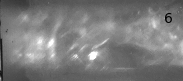

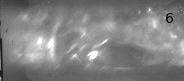

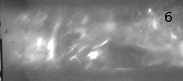

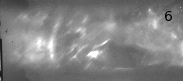

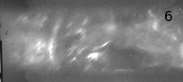

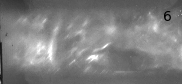

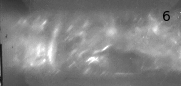

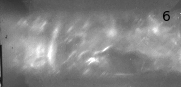

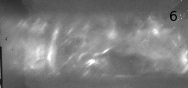

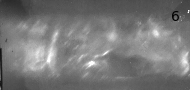

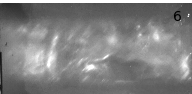

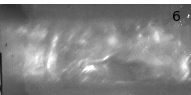

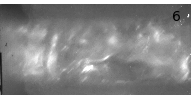

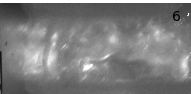

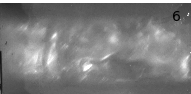

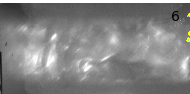

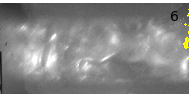

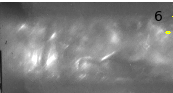

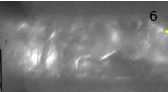

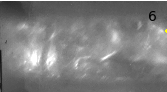

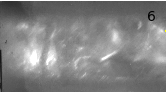

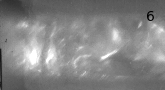

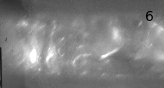

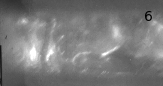

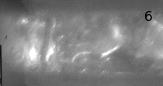

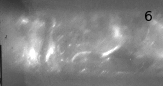

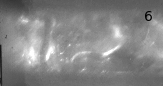

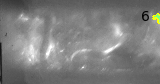

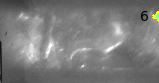

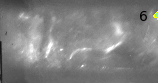

In [103]:
#LIME('drive/My Drive/PRD/automobile-engine-rotation-velocity-master/train/500_8_1_Gly', nb_images= 200)
#LIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 30,number_features = 3, number_samples = 100)
#LIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 15,number_features = 4, number_samples = 4000)
LIME('drive/My Drive/PRD/Tests/200_8_1_Debut','drive/My Drive/PRD/resultats/', segmentation_hierarchie = 35,number_features = 1, number_samples = 10)
"""
LIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/200_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/400_8_1_Debut',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/400_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/400_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/600_8_1_Debut',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/600_8_1_Milieu',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)
LIME('drive/My Drive/PRD/Tests/600_8_1_Fin',segmentation_hierarchie = 35,number_features = 1, number_samples = 1000)

LIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 30,number_features = 3, number_samples = 2000)
LIME('drive/My Drive/PRD/Tests/200_8_1_Milieu',segmentation_hierarchie = 15,number_features = 5, number_samples = 3000)
"""


In [0]:
LIME_test('drive/My Drive/PRD/Test/Videos/Rotary_motion/Rotary_motion_g5_c84.mp4',segmentation_hierarchie = 30,number_features = 6, number_samples = 1000)

In [0]:
!rm -rf /content/Geyser_g1_c25.mp4_video
!rm -rf /content/Geyser_g1_c25.mp4_video_flow
!rm -rf /content/Geyser_g1_c25.mp4_video_out
!rm -rf /content/Geyser_g1_c25.mp4_video_vis
